# TDS - Final Project [Covid-19 DataSet](https://www.kaggle.com/datasets/meirnizri/covid19-dataset)
### Sean Goldfarb - 209320977
### Lior Itzhak - 203679816

# Initialization

In [ ]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.model_selection import cross_validate, KFold, train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, balanced_accuracy_score

In [ ]:
pd.options.mode.chained_assignment = None

np.random.seed(0) # make random deterministic
sns.set(style="darkgrid")

In [ ]:
skip_benchmark_model_train = True
skip_train_on_missing_values = True
skip_final_model_train = True

## Opening The Dataset

# Dataset Cleaning
It's evident that much of the data is in a raw state, requiring cleaning to improve its usability.

We introduced a new column named "DIED" to facilitate analysis. If the "DATE_DIED" column contains the value "9999-99-99", indicating the patient survived, we assigned `False` to the corresponding row in the "DIED" column. Otherwise, we assigned `True`.


In [5]:
raw_df['DIED'] = raw_df['DATE_DIED'] != '9999-99-99'
raw_df = raw_df.drop(columns=["DATE_DIED"])

In the Boolean features, the value 1 signifies yes, while 2 indicates no. Any values such as 97, 98 and 99 represent missing data. Thus, we converted 1 to `True` and 2 to `False`. Additionally, we identified all columns containing missing data and replaced occurrences of `[97, 98, 99]` with `None`.

In [6]:
boolean_column = ['INTUBED', 'PNEUMONIA', 'PREGNANT', 'ICU', 'DIABETES',
                  'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR',
                  'OBESITY' , 'RENAL_CHRONIC', 'TOBACCO', 'ASTHMA', "COPD"]

for col in boolean_column:
  raw_df.loc[raw_df[col].isin([97, 98, 99]), col] = None
  raw_df.loc[raw_df[col] == 2, col] = False
  raw_df.loc[raw_df[col] == 1, col] = True

We discovered that the "PREGNANT" column consistently contains `None` values for male patients. therefore, we assigned a `False` value to all male patients in this column.

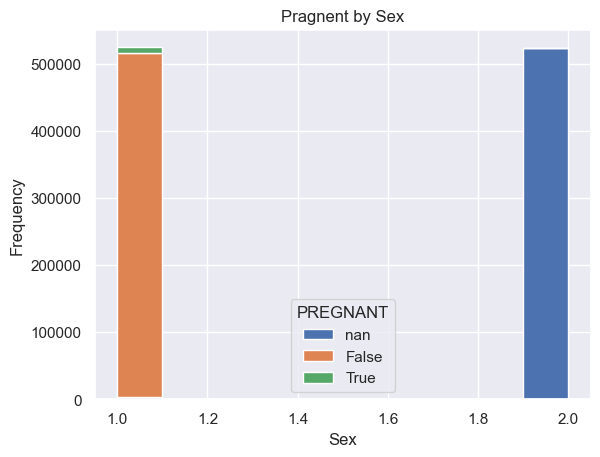

In [7]:
raw_df.pivot(columns='PREGNANT')['SEX'].plot.hist(xlabel='Sex', stacked=True)
raw_df.loc[raw_df['SEX']==2, 'PREGNANT'] = False

plt.title("Pragnent by Sex")
plt.show()

After analyzing  the data, we concluded that our objective shouldn't solely be to predict whether a patient will die or not. Most, if not all, existing approaches focus solely on this aspect. However, in real-world scenarios, predicting a patient's outcome when they're already in the ICU and intubated seems less practical. Instead, our goal is forecasting the severity of their illness when they receive their Covid test results. To do so we need to focus on their pre-existing conditions rather than their symptoms or the type of medical treatment they received.

To achieve this, we've divided the columns into two groups:
1. Pre-Existing Conditions - These are conditions that existed before the patient received their COVID-19 test results.
  * sex: 1 for female and 2 for male.
  * age: of the patient.
  * pregnancy: whether the patient is pregnant or not.
  * diabetes: whether the patient has diabetes or not.
  * copd: Indicates whether the patient has Chronic obstructive pulmonary disease or not.
  * asthma: whether the patient has asthma or not.
  * inmsupr: whether the patient is immunosuppressed or not.
  * hypertension: whether the patient has hypertension or not.
  * other disease: whether the patient has other disease or not.
  * cardiovascular: whether the patient has heart or blood vessels related disease.
  * obesity: whether the patient is obese or not.
  * renal chronic: whether the patient has chronic renal disease or not.
  * tobacco: whether the patient is a tobacco user.
  * pneumonia: whether the patient already have air sacs inflammation or not.
  * classification: covid test findings. Values 1-3 mean that the patient was diagnosed with covid in different.
  degrees. 4 or higher means that the patient is not a carrier of covid or that the test is inconclusive.
2. Symptoms - These are conditions that emerged as a result of their illness and therefore cannot be utilized as input for our model.
  * patient type: type of care the patient received in the unit. 1 for returned home and 2 for hospitalization.
  * intubed: whether the patient was connected to the ventilator.
  * icu: Indicates whether the patient had been admitted to an Intensive Care Unit.
  * died: whether the patient dies or not.
3. Medical treatment - These columns indicate the type of care the patient received after falling ill, so they cannot be used.
  * usmr: Indicates whether the patient treated medical units of the first, second or third level.
  * medical unit: type of institution of the National Health System that provided the care.

# Prediction Goal

We've introduced a new column representing illness severity, which we aim to predict.

When severity is 0, it indicates a mild illness with minimal impact, and the patient can manage it at home. Severity 1 suggests the patient might need some medical care or monitorized, hence, the need for hospitalization. Severity 2 signifies a critical condition where the patient faces a high risk of significant Covid-related symptoms, potentially requiring ICU admission and intubation, with a risk of mortality.

In [8]:
# Create new severity column
raw_df.loc[raw_df["PATIENT_TYPE"] == 1, "SEVERITY"] = 0
raw_df.loc[raw_df["PATIENT_TYPE"] == 2, "SEVERITY"] = 1
raw_df.loc[(raw_df["DIED"] == True) | (raw_df["ICU"] == True) | (raw_df["INTUBED"] == True), "SEVERITY"] = 2

raw_df['SEVERITY'] = raw_df['SEVERITY'].astype(int)

# drop symptoms & irelavent columns
raw_df = raw_df.drop(columns=['PATIENT_TYPE', 'ICU', 'DIED', 'INTUBED', 'USMER', 'MEDICAL_UNIT'])

SEVIRITY_COLORS = {
    0: 'green',
    1: 'yellow',
    2: 'orange',
  }

# Benchmark Model

base on  XGBoost Classifier without feature enginerring

In [9]:
df = raw_df.copy()
train_idx, test_idx = train_test_split(np.arange(df.shape[0]), test_size=0.2)

In [10]:
raw_df_train, raw_df_test = df.iloc[train_idx], df.iloc[test_idx]
df_train, df_test = raw_df_train, raw_df_test

X_train, y_train = df_train.drop(columns=['SEVERITY']).to_numpy(), np.hstack(df_train['SEVERITY'].to_numpy())
X_test, y_test = df_test.drop(columns=['SEVERITY']).to_numpy(), np.hstack(df_test['SEVERITY'].to_numpy())

## Train Model

In [11]:
if skip_benchmark_model_train:
  print('Skipping benchmark model training, using saved model.')
  with open('benchmark_model.pkl', 'rb') as file:
    baseline_clf = pickle.load(file)
else:
  baseline_clf = XGBClassifier(random_state=13)
  baseline_clf.fit(X_train, y_train)


  # Save model for future use
  with open('benchmark_model.pkl','wb') as file:
    pickle.dump(baseline_clf, file)

y_predict = baseline_clf.predict(X_test)

## Model Performance

### Cross-Validate

In [12]:
if skip_benchmark_model_train:
  print('Skipping benchmark model cross validation, using saved scores.')
  with open('benchmark_model_scores.pkl', 'rb') as file:
    benchmark_model_scores = pickle.load(file)
else:
  kfold = KFold(n_splits=10, random_state=13, shuffle=True)
  benchmark_model_scores = cross_validate(baseline_clf, X_train, y_train, cv=kfold,
                                          scoring=('accuracy', 'balanced_accuracy'), return_train_score=True,
                                          n_jobs=-1)

  # Save model for future use
  with open('benchmark_model_scores.pkl','wb') as file:
    pickle.dump(benchmark_model_scores, file)

print(f'CV Train Accuracy: {benchmark_model_scores["train_accuracy"]}\n')
print(f'CV Test Accuracy: {benchmark_model_scores["test_accuracy"]}\n')
print(f'CV Train Balanced Accracy: {benchmark_model_scores["train_balanced_accuracy"]}\n')
print(f'CV Test Balanced Accracy: {benchmark_model_scores["test_balanced_accuracy"]}')

CV Train Accuracy: [0.86503906 0.86476355 0.86487482 0.86477283 0.86458871 0.86475031
 0.86459136 0.86509734 0.86499932 0.86490793]

CV Test Accuracy: [0.86089455 0.86195551 0.86211048 0.86153828 0.86307608 0.86414896
 0.86394631 0.86119257 0.85922562 0.86139523]

CV Train Balanced Accracy: [0.60180475 0.6024171  0.60161255 0.6023465  0.60213912 0.6025711
 0.60175594 0.60346097 0.60263424 0.60214867]

CV Test Balanced Accracy: [0.59206821 0.59575324 0.59379491 0.59273046 0.59820964 0.59399338
 0.59804024 0.59445161 0.59088868 0.59371834]


### Evaluation Metrics

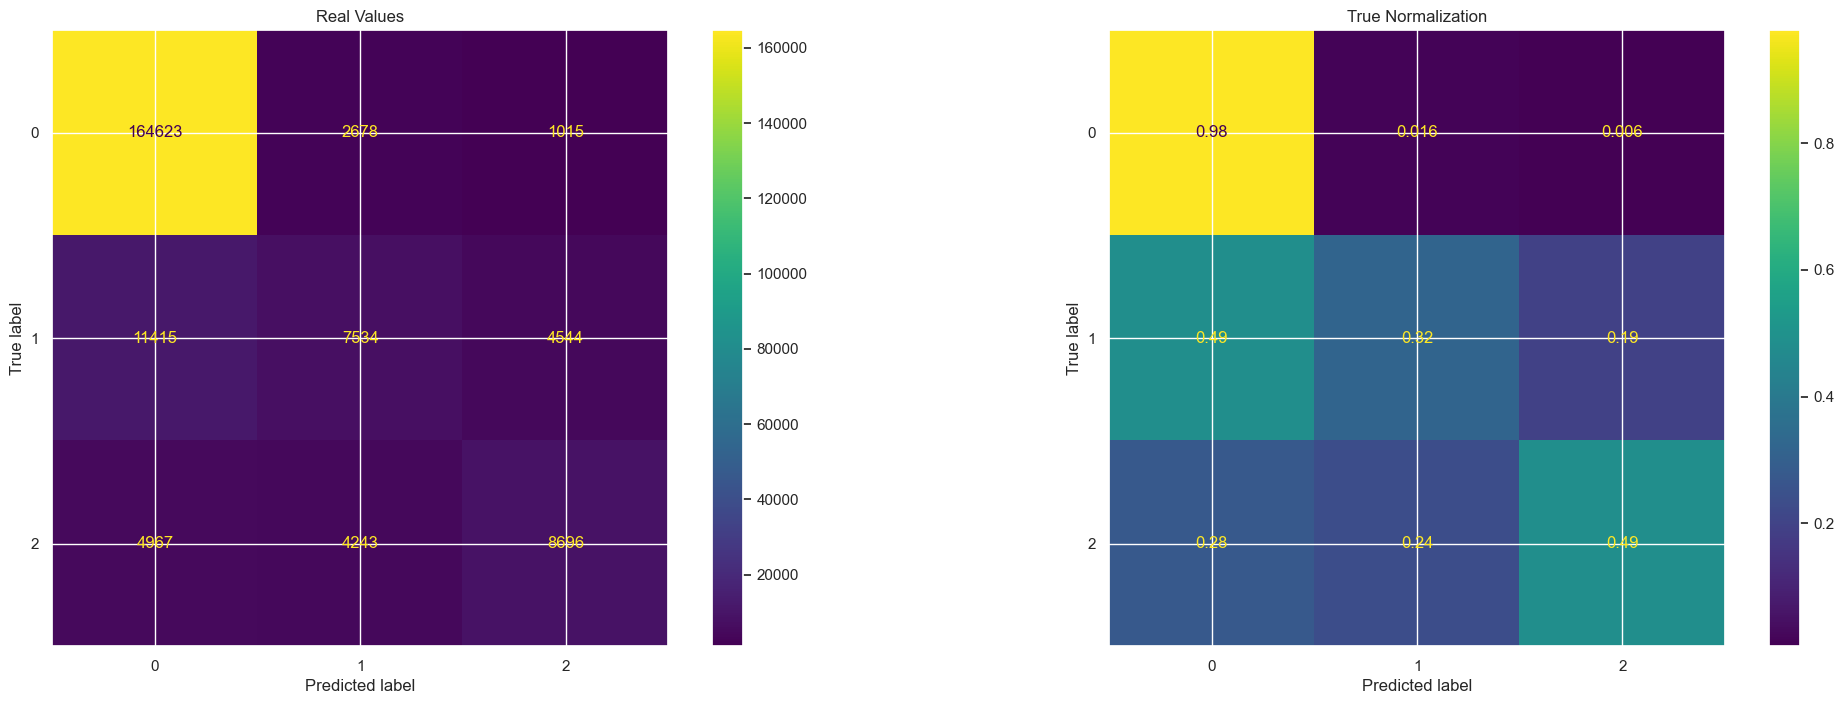

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(25,8))
cm = confusion_matrix(y_test, y_predict)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(ax=ax[0])
ax[0].set_title('Real Values');

cm = confusion_matrix(y_test, y_predict, normalize='true')
ConfusionMatrixDisplay(confusion_matrix=cm).plot(ax=ax[1])
ax[1].set_title('True Normalization');

plt.show()

Those two confusion matrix are essential tool for performance analyisis

the left confusion matrix shows the overall prediction vs the correct label, here we see a heavy over representation of the severity 0 among the true labels, which makes it easy to get overall accuracy of around 80% just by predicting 0 every time - this is why we are also evaluating an overall balanced accuracy


the central confusion matrix is normalized by the true labels. true-normalized confusion matrix is a way to evaluate the performance of a classification model by displaying the proportion of true positive, true negative, false positive, and false negative predictions, normalized with respect to the actual distribution of classes in the dataset.
The low sensitivity in identifying severity 2 (high-risk cases) and the significant false negatives in this class are concerning. This indicates that our model tends to misclassify high-risk individuals as having low severity. In healthcare applications, especially when dealing with severe conditions like COVID-19, it's crucial to minimize such errors to ensure appropriate patient care.

Focusing on reducing false negatives, particularly in the blocks under the diagonal, is paramount. While this may lead to a slight decrease in overall accuracy, prioritizing the accurate identification of high-risk cases is essential for patient safety and effective healthcare management. By addressing these misclassifications, we can enhance the model's performance and reliability in identifying individuals who require urgent attention and intervention.

In [14]:
benchmark_overall_accuracy = accuracy_score(y_test, y_predict)
benchmark_balanced_accuracy_score = balanced_accuracy_score(y_test, y_predict)

print(f'overall accuracy: {benchmark_overall_accuracy: .2f}' )
print(f'overall balanced accuracy: {benchmark_balanced_accuracy_score: .2f}' )

df_test["pred"] = y_predict

# our sestivity (TPR) of identfying high risk individuals
# TPR = TP / P : positive - high risk (severity 2)
benchmark_sensitivity = df_test[(df_test["SEVERITY"] == 2) & (df_test["pred"] == 2)].shape[0] / df_test[(df_test["SEVERITY"] == 2)].shape[0]
print(f"Sensitivity (TPR):{benchmark_sensitivity : .2f}")

# TNR = TN / N : positive - high risk (severity 2)
benchmark_specificity = df_test[(df_test["SEVERITY"] != 2) & (df_test["pred"] != 2)].shape[0] / df_test[(df_test["SEVERITY"] != 2)].shape[0]
print(f"Speificity (TNR):{benchmark_specificity : .2f}")

# FNR = FN / P
benchmark_FNR = df_test[(df_test["SEVERITY"] == 2) & (df_test["pred"] == 0)].shape[0] / df_test[(df_test["SEVERITY"] == 2)].shape[0]
print(f"FNR:{benchmark_FNR : .2f}, type 2 errors")

overall accuracy:  0.86
overall balanced accuracy:  0.59
Sensitivity (TPR): 0.49
Speificity (TNR): 0.97
FNR: 0.28, type 2 errors


Although our model achieves more than 80% accuracy rate, it's important to note the heavy imbalance in the data, which results in a less impressive balanced overall accuracy, falling around 60%.

However, our primary objective isn't solely centered on accuracy measurement. We're particularly concerned about the model's difficulty in predicting high severity instances accurately, to avoid potential harm, especially in contexts involving human life. Therefore, our focus is on minimizing misclassifications of individuals as non-risk, prioritizing the reduction of the False Negative Rate (FNR) to enhance patient safety.

problems with the benchmark models:

- High FNR:  We want to classifiy whether or not we should pay attention to the patient, we want to be more sensetive about missclassification of high severity, and care less about missclassification of low severity.
therfore, optimize the overall accuracy isn't our main goal, we aim to optimize the type 2 error, meaning, to reduce the probability of classifying high-risk individual as no-risk

- Overfitting: leading to  inconsist prediction (that we will demonstrate below)


### Sanity Check - Consistency

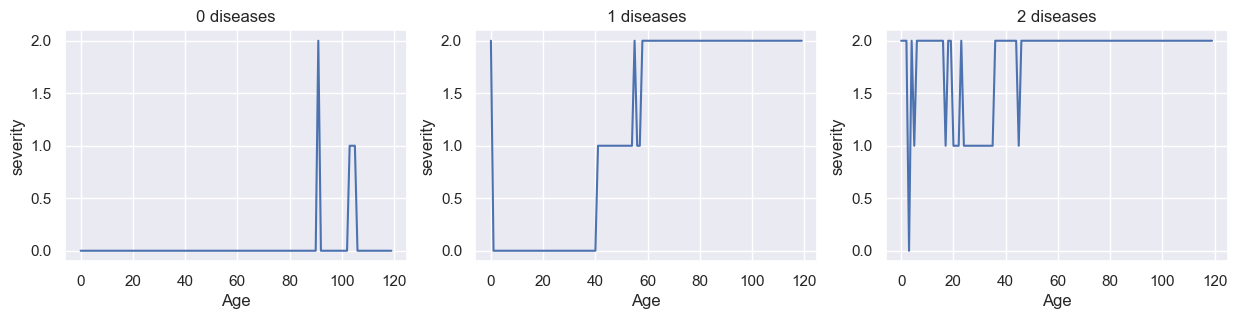

In [15]:
demo_profile_df = pd.DataFrame(index=pd.RangeIndex(1), columns=df_train.columns)
demo_profile_df["SEX"] = 1
demo_profile_df["CLASIFFICATION_FINAL"] = 1
demo_profile_df = demo_profile_df.fillna(False)
demo_profile_df = pd.concat([demo_profile_df]*120,ignore_index=True)
demo_profile_df['AGE'] = np.arange(0, 120)

fig = plt.figure(figsize=(15, 3))
for i, column in enumerate([None, 'PNEUMONIA', 'RENAL_CHRONIC']):
  if column is not None:
    demo_profile_df[column] = True
  demo_profile_df["SEVERITY"] = baseline_clf.predict(demo_profile_df.drop(columns=['SEVERITY']).to_numpy())
  demo_profile_df["SEVERITY"].plot.line(xlabel='Age', ylabel='severity', ylim=(-0.1, 2.1), title=f'{i} diseases', ax=fig.add_subplot(1,3,i+1))

In this instance, we utilized 3 patient profiles differ by their pre-conditions, for each we tuned the age across the range from 0 to 119. This approach allows us to observe the influence of age on predictions.

We expected to observe an uninterrupted step graph without of sudden shifts between predictions resembling spikes. Predictions for consecutive ages were expected to align.

The irregularities describe a behavior that doesn't make sense, a patient that is 100+ years old, can't have a lower risk prediction than a younger patient with the same profile. This occurs due to overfitting to precise ages in the training data. The prediction becomes excessively tailored to the age variable, leading to inconsistent outcomes when certain age points lack sufficient representation.

This inconsistency leads to an untrustable model that we can't adopt in the healthcare system.

# Improved Pipeline

## Feature Enhencement

In [16]:
df = raw_df.copy()

### CLASIFFICATION_FINAL

We observe an irregular pattern in the "CLASIFFICATION_FINAL" column. Its frequency distribution is notably inconsistent. Also, for the category "CLASIFFICATION_FINAL" 2, despite being received by very few patients (only 1,851 out of 1,048,575), all patients with this classification died.

Since we cannot definitively ascertain whether the values represent a ratio, interval, or ordinal scale, we opt to create a new column based on its definition:
If the "CLASIFFICATION_FINAL" value is less than or equal to 3, the patient is diagnosed with COVID-19; otherwise, the test result is uncertain.












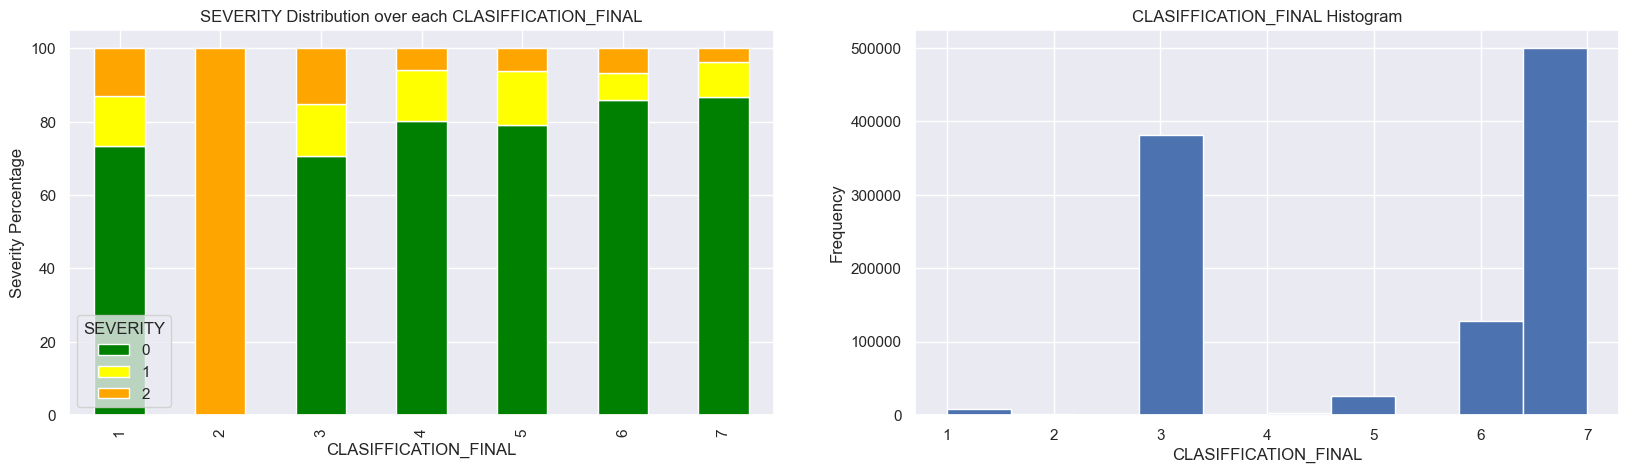

In [17]:
fig = plt.figure(figsize=(20,5))

df['CLASIFFICATION_FINAL'].plot.hist(ax=fig.add_subplot(1, 2, 2), xlabel='CLASIFFICATION_FINAL')
plt.title("CLASIFFICATION_FINAL Histogram")
df\
    .groupby(["CLASIFFICATION_FINAL", 'SEVERITY']).size()\
    .groupby("CLASIFFICATION_FINAL", group_keys=False)\
    .apply(lambda x: 100 * x / x.sum()).unstack()\
    .plot.bar(stacked=True, color=SEVIRITY_COLORS, ax=fig.add_subplot(1, 2, 1), ylabel='Severity Percentage')

plt.title("SEVERITY Distribution over each CLASIFFICATION_FINAL")
plt.show()

In [18]:
df["COVID"] = df["CLASIFFICATION_FINAL"] <= 3
df = df.drop(columns=["CLASIFFICATION_FINAL"])

### Managing Missing Features
As observed initially, some features might contain "None" values. Our approach involves filling these missing values based on information from other rows in the training data.








In [19]:
(df!=df).sum()

SEX                   0
PNEUMONIA         16003
AGE                   0
PREGNANT           3754
DIABETES           3338
COPD               3003
ASTHMA             2979
INMSUPR            3404
HIPERTENSION       3104
OTHER_DISEASE      5045
CARDIOVASCULAR     3076
OBESITY            3032
RENAL_CHRONIC      3006
TOBACCO            3220
SEVERITY              0
COVID                 0
dtype: int64

To address these missing values, we implemented a NaiveBayes model for each column to predict the absent values based on the other provided columns. We chose this model due to its simplicity & efficiency

In [20]:
columns_to_predict = ['RENAL_CHRONIC', 'COPD', 'PREGNANT', 'CARDIOVASCULAR', 'INMSUPR', 'HIPERTENSION','DIABETES', 'PNEUMONIA', 'OTHER_DISEASE','OBESITY','TOBACCO', 'ASTHMA']

if skip_train_on_missing_values:
  print('Skipping column models training, using saved models.')
  with open('columns_models.pkl', 'rb') as f:
    column_models = pickle.load(f)
else:
  df_train = df.iloc[train_idx]

  column_models = dict()
  for column in columns_to_predict:
    clf_c = CategoricalNB()

    df_c = df_train[~df_train[column].isna()]
    X_c, y_c = df_c.drop(columns=['SEVERITY', column]).fillna(False).to_numpy(), np.hstack(df_c[column].to_numpy())
    column_models[column] = clf_c.fit(X_c, y_c)

  # Save models for future use
  with open('columns_models.pkl','wb') as file:
    pickle.dump(column_models, file)

After Training, we can now predict all the the missing values for our columns

In [21]:
def predict_column(df, column):
  mask = df[column].isna()
  if mask.sum() > 0:
    X_c = df[mask].drop(columns=['SEVERITY', column]).fillna(False).to_numpy()
    df.loc[mask, column] = column_models[column].predict(X_c).astype(bool)

for column in columns_to_predict:
  predict_column(df, column)

In [22]:
(df!=df).sum()

SEX               0
PNEUMONIA         0
AGE               0
PREGNANT          0
DIABETES          0
COPD              0
ASTHMA            0
INMSUPR           0
HIPERTENSION      0
OTHER_DISEASE     0
CARDIOVASCULAR    0
OBESITY           0
RENAL_CHRONIC     0
TOBACCO           0
SEVERITY          0
COVID             0
dtype: int64

### Number Of Background Diseases
We're substantiating our intuition that individuals with multiple underlying health conditions are at a heightened risk of severe COVID. This finding reinforces our understanding and adds this significant feature to our analysis

In [23]:
df['N_BACKGROUND_DISEASES'] = 0
for c in ['DIABETES', 'COPD', 'ASTHMA', 'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC']:
  df['N_BACKGROUND_DISEASES'] += df[c] == True

df['N_BACKGROUND_DISEASES'] = df['N_BACKGROUND_DISEASES'].astype(int)

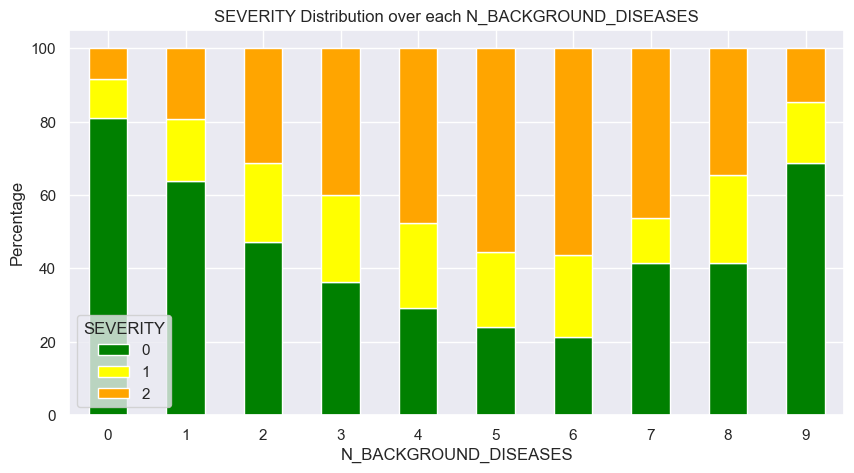

In [24]:
df[df["COVID"] == True]\
    .groupby(["N_BACKGROUND_DISEASES", 'SEVERITY']).size()\
    .groupby("N_BACKGROUND_DISEASES", group_keys=False).apply(lambda x: 100 * x / x.sum()).unstack()\
    .plot(kind='bar',stacked=True, rot=0, figsize=(10, 5),
          ylabel='Percentage', color={**SEVIRITY_COLORS})

plt.title("SEVERITY Distribution over each N_BACKGROUND_DISEASES")
plt.show()

In [25]:
df[df['N_BACKGROUND_DISEASES'] >= 6].shape[0], df[df['N_BACKGROUND_DISEASES'] < 6].shape[0]

(765, 1047810)

We've observed an unexpected behavior in our data analysis. Up until a count of 6, there's a clear positive correlation between the number of background diseases and severity. However, unexpectedly, when the number of diseases exceeds 6, we observe a negative correlation.

This unexpected pattern could lead to inconsistent classifications. Typically, when adding background diseases, we would expect to increase the probability of high severity. However, this reversal in correlation challenges our assumptions.

A potential explanation for this behavior could be the tiny number of records with more than 5 diseases. To address this issue and ensure more consistent classifications, we propose implementing an upper limit for the number of diseases, such as 5, thereby mitigating the impact of the unexpected correlation reversal.

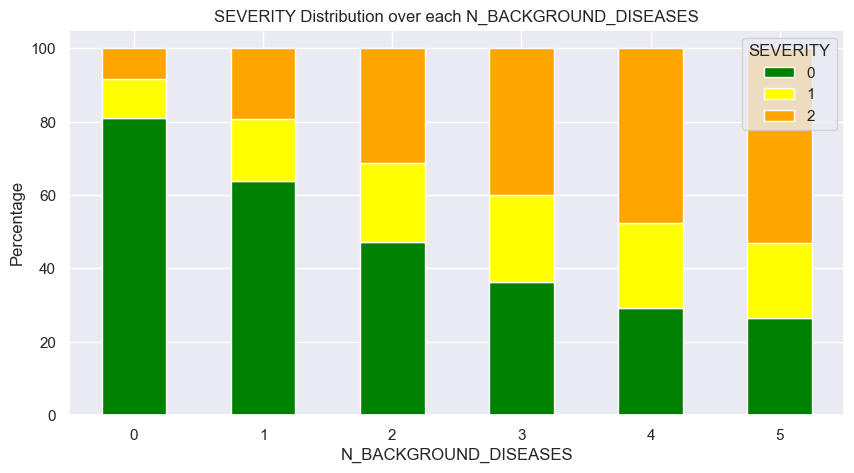

In [26]:
df.loc[df['N_BACKGROUND_DISEASES'] >=5, "N_BACKGROUND_DISEASES" ] = 5

df[df["COVID"] == True]\
    .groupby(["N_BACKGROUND_DISEASES", 'SEVERITY']).size()\
    .groupby("N_BACKGROUND_DISEASES", group_keys=False).apply(lambda x: 100 * x / x.sum()).unstack()\
    .plot(kind='bar',stacked=True, rot=0, figsize=(10, 5),
          ylabel='Percentage', color={**SEVIRITY_COLORS})


plt.title("SEVERITY Distribution over each N_BACKGROUND_DISEASES")
plt.show()

### Feature importance
We want to examine our feature importance by testing its correlation with the prediction target (severity)

#### Age
Evaluating the age feature and its assosiation with the severity

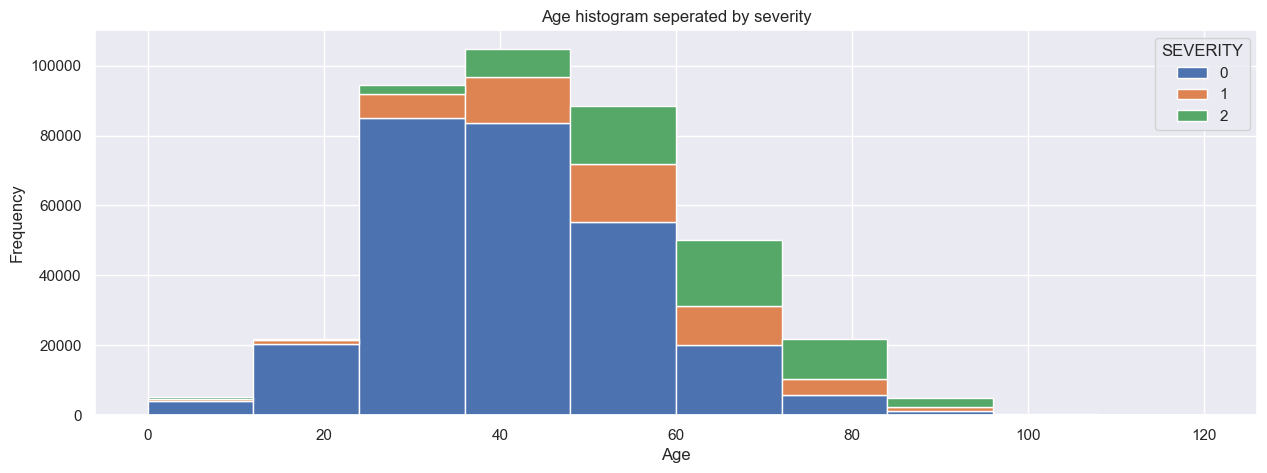

In [27]:
df[df["COVID"] == True].pivot(columns=['SEVERITY'])["AGE"].plot.hist(xlabel='Age', figsize=(15, 5), stacked=True)


plt.title("Age histogram seperated by severity")
plt.show()

There appears to be a strong association between age and severity. We demonstrates this positive correlation below, which aligns with our expectation

#### Boolean Features Importance
We aim to assess the distinctiveness of each boolean feature concerning the prediction target.


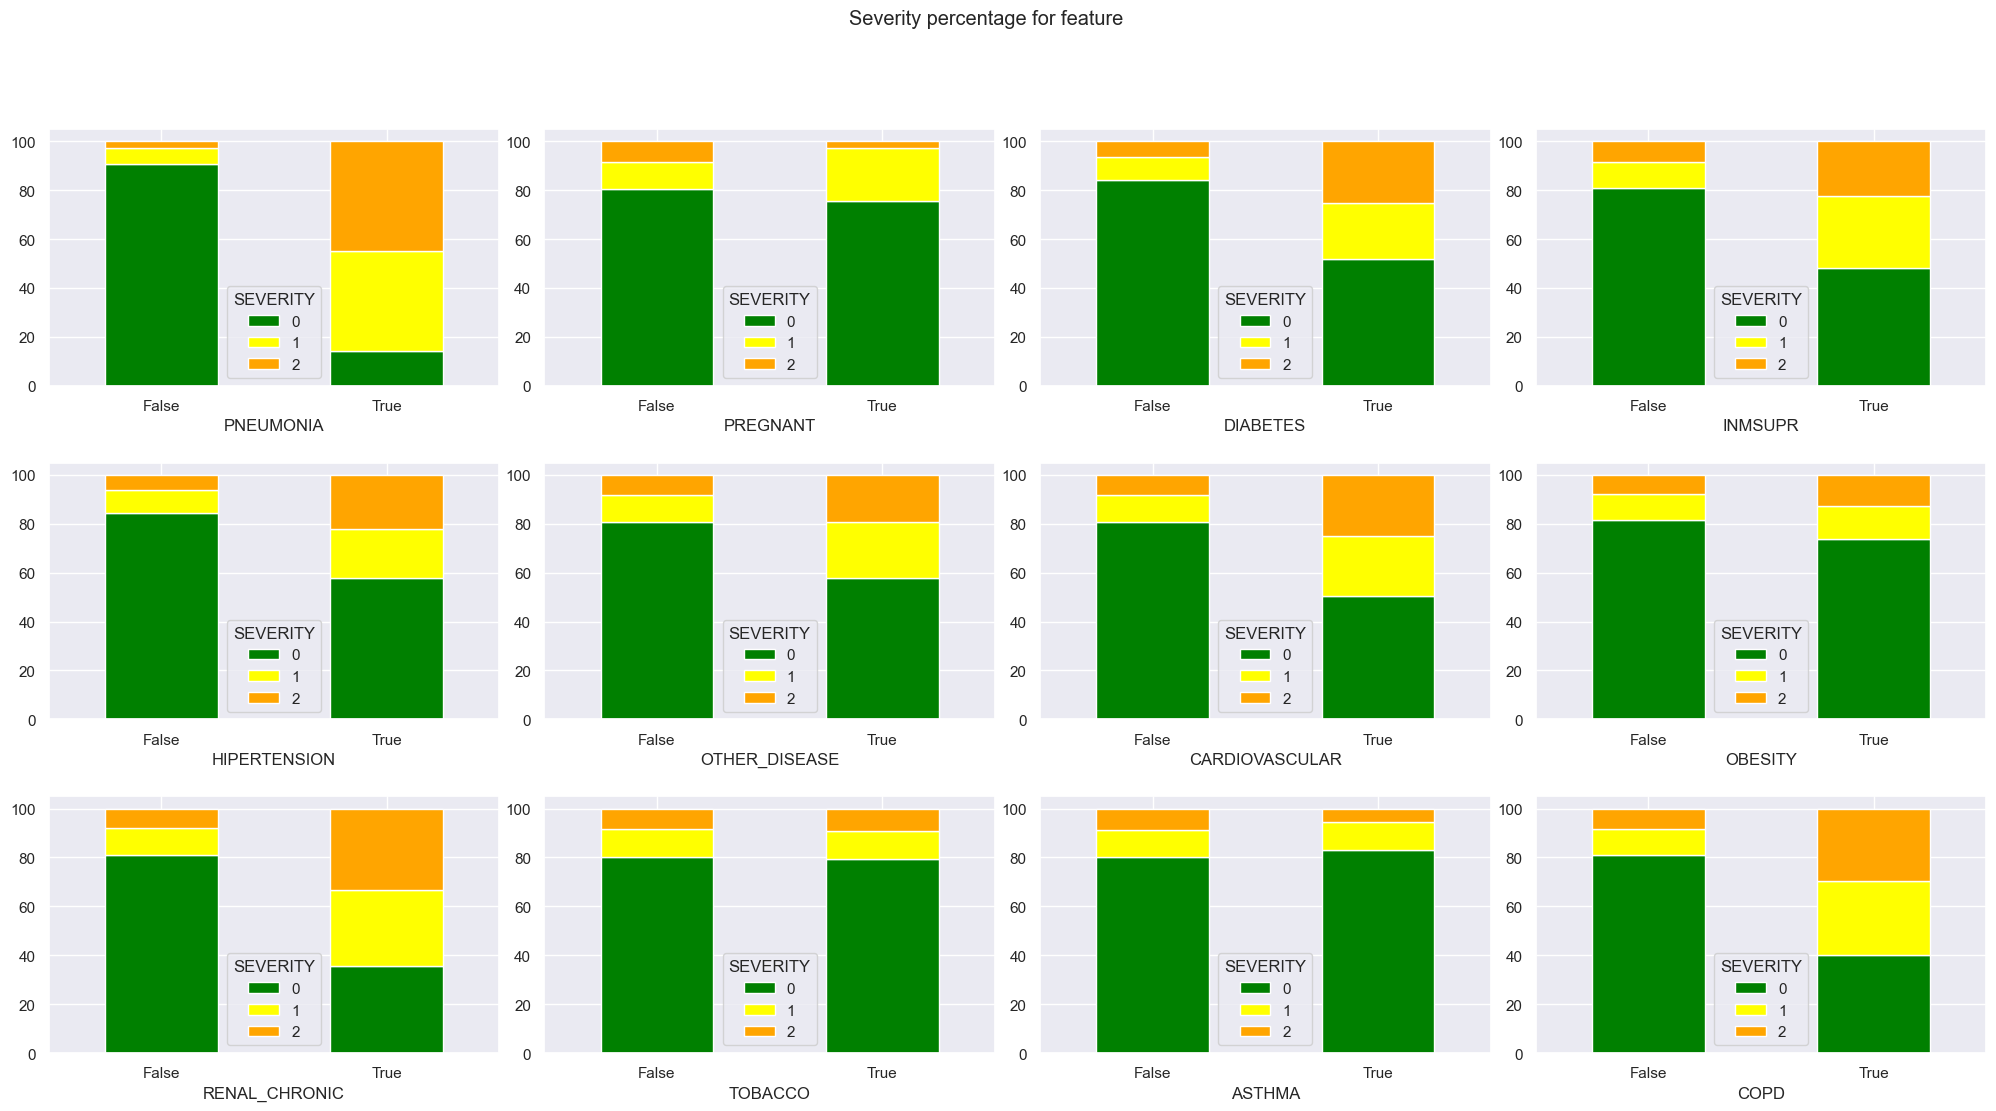

In [28]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.3, wspace=0.1)

for idx, c in enumerate(['PNEUMONIA', 'PREGNANT', 'DIABETES','INMSUPR',
                         'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR',
                         'OBESITY' , 'RENAL_CHRONIC', 'TOBACCO', 'ASTHMA', "COPD"]):
  df\
    .groupby([c, 'SEVERITY']).size()\
    .groupby(c, group_keys=False).apply(lambda x: 100 * x / x.sum()).unstack()\
    .plot(kind='bar',stacked=True, rot=0, figsize=(25, 12), ax=fig.add_subplot(3, 4, idx+1),
          color={**SEVIRITY_COLORS})
plt.suptitle('Severity percentage for feature')
plt.show()


We can identify several key features that, when present alone, provide significant insights into the patient's risk for severe conditions:

PNEUMONIA: Its presence indicates a high risk, with over 80% of patients who have it being classified at severity level 1 or above (approximately 40% classified with the highest risk).
Other indicators of high risk include COPD, REAL_CHRONIC, CARDIOVASCULAR, INMSUPR, DIABETES, and HIPERTENSION.
Interestingly, certain pre-existing conditions such as smoking tobacco and asthma appear to have no discernible effect on the severity risk, at least not when considered independently.

#### Feature Correlation

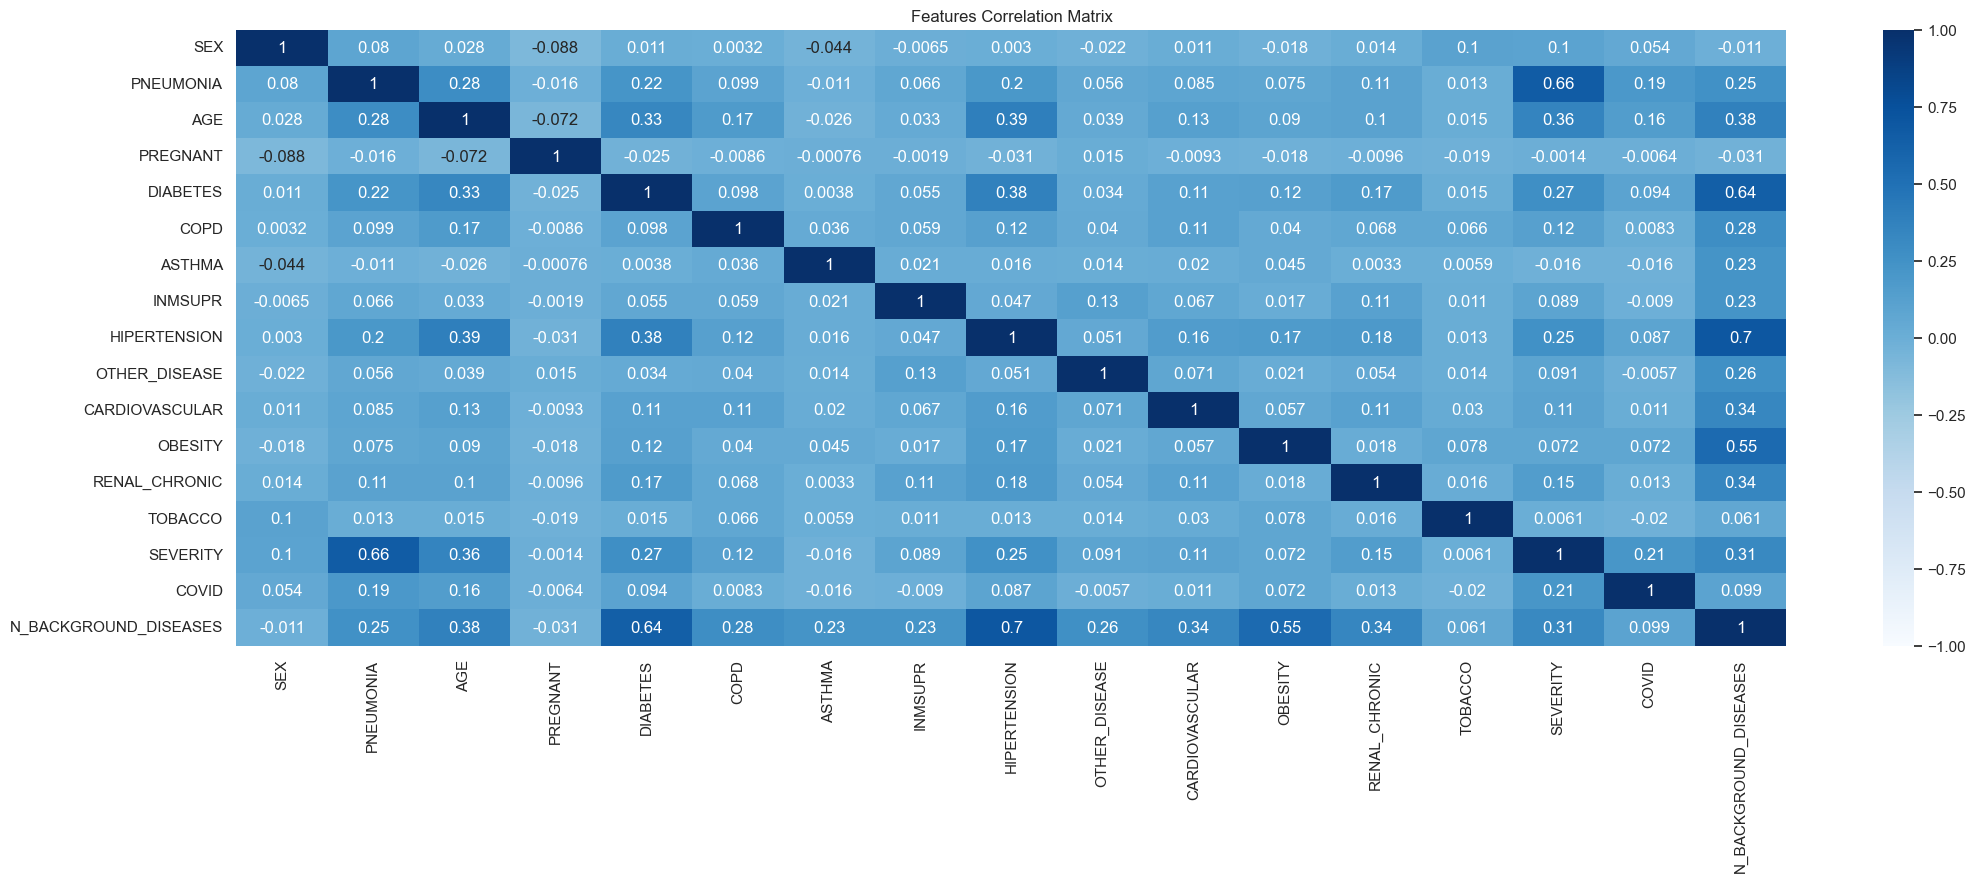

In [29]:
fig, ax = plt.subplots(figsize=(25,8))
correlation_df = df.corr(method='pearson',numeric_only=False)
sns.heatmap(correlation_df, annot=True, cmap="Blues", vmin=-1, vmax=1, ax=ax)


plt.title("Features Correlation Matrix")
plt.show()

The correlation matrix highlights strong features associated with severity:

PNEUMONIA, AGE, N_BACKGROUND_DISEASES, DIABETES, HIPERTENSION, COVID, and RENAL_CHRONIC exhibit relatively high positive correlations with severity.
Additionally, moderate features include SEX, COPD, and CARDIOVASCULAR.

there are features, such as ASTHMA and TOBACCO (surprisingly), which do not show significant correlations with severity


It's interesting to note that removing low-correlated features from our model actually improves overall performance and enhances consistency by reducing overfitting. This suggests that these features may introduce noise into the model without providing significant predictive value. Simplifying the model in this way not only improves its performance but also makes it easier to interpret and maintain.

Additionally, it's worth mentioning that much of the information from individual background diseases may be encapsulated in the number of diseases feature. By removing redundant features related to individual diseases, we can streamline the model and achieve better performance.

Overall, simplifying the model by removing low-correlated features and redundant individual disease information not only results in a more robust and consistent model but also creates a simpler pipeline that is easier to analyze and maintain. This streamlined approach enhances the model's practical utility and facilitates its integration into real-world healthcare systems.

In [30]:
df = df.drop(columns=['DIABETES', 'HIPERTENSION', 'RENAL_CHRONIC',
    'COPD', 'ASTHMA', 'INMSUPR', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY',
    "TOBACCO", "PREGNANT"])

In [31]:
df_train, df_test = df.iloc[train_idx], df.iloc[test_idx]

### Over Sampling

Given the heavy imbalance in our data, with non-risk instances (severity 0) being overrepresented, there's a risk of inappropriate predictions and bias. To address this issue, We tried weights, under-sampeling and over-sampeling. After reviewing their results we chose to employe oversampling techniques on records with fewer representatives, particularly those with severity levels 1 and 2.

Furthermore, over-sampling lets us to introduce additional variance into the dataset, we implement augmentations, particularly focusing on the age column. This approach aims to improve the model's ability to generalize across different age groups and reduce the potential for overfitting.

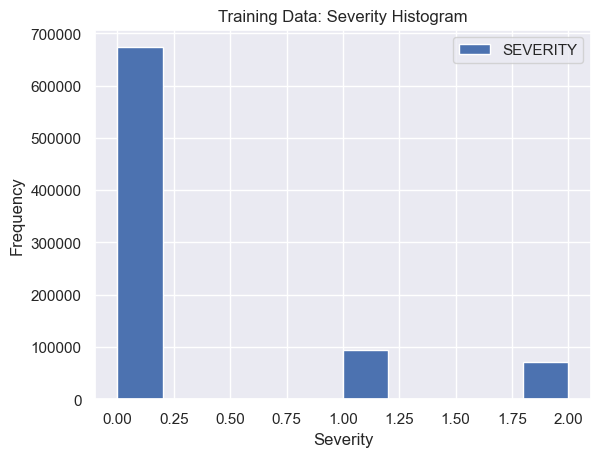

In [32]:
df_train[["SEVERITY"]].plot.hist(xlabel='Severity')

plt.title("Training Data: Severity Histogram")
plt.show()

In [33]:
resample_size = df_train[df_train['SEVERITY']==0].shape[0] // df_train[df_train['SEVERITY']==1].shape[0]
df_copy = pd.concat([df_train[df_train['SEVERITY']==1].copy()] * resample_size, ignore_index=True)
df_train = pd.concat([df_train, df_copy], ignore_index=True)

resample_size = df_train[df_train['SEVERITY']==0].shape[0] // df_train[df_train['SEVERITY']==2].shape[0]
df_copy = pd.concat([df_train[df_train['SEVERITY']==2].copy()] * resample_size, ignore_index=True)
df_train = pd.concat([df_train, df_copy], ignore_index=True)

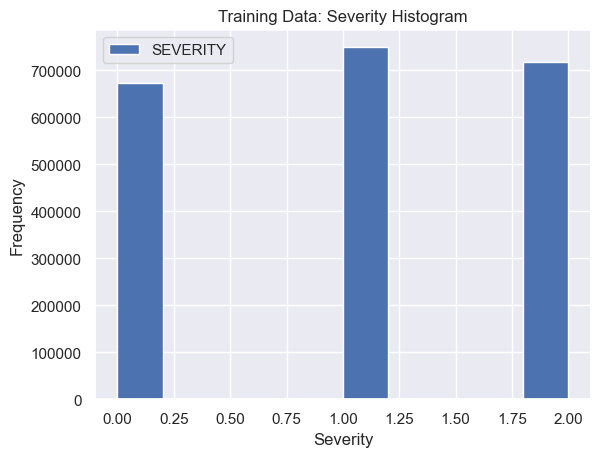

In [34]:
df_train[["SEVERITY"]].plot.hist(xlabel='Severity')
plt.title("Training Data: Severity Histogram")
plt.show()

### Augmenting Age
We are adding normal distributed noise to the age column. This allows the model to better generalize this column and not overfit around specific ages.

In [35]:
# fighting overfiiting of the age column by adding random noise
df_train.loc[:,'AGE'] =  (df_train['AGE'] + np.random.normal(0, (df_train['AGE']/10)+5, df_train.shape[0])).abs().round().astype(int)

In [36]:
df_train

,SEX,PNEUMONIA,AGE,SEVERITY,COVID,N_BACKGROUND_DISEASES
0,2,False,28,0,True,2
1,2,False,39,0,False,1
2,2,False,28,0,False,0
3,1,False,22,0,True,1
4,1,False,41,1,True,1
...,...,...,...,...,...,...
2141103,2,False,84,2,False,3
2141104,2,True,27,2,True,0
2141105,1,True,36,2,True,0
2141106,1,True,68,2,True,1


## Train Model

In [37]:
X_train, y_train = df_train.drop(columns=['SEVERITY']).to_numpy(), np.hstack(df_train['SEVERITY'].to_numpy())
X_test, y_test = df_test.drop(columns=['SEVERITY']).to_numpy(), np.hstack(df_test['SEVERITY'].to_numpy())

In [38]:
print(f'training upon: {df_train.drop(columns=["SEVERITY"]).columns} features')

if skip_final_model_train:
  print('Skipping final model training, using saved model.')
  with open('final_model.pkl', 'rb') as file:
    clf = pickle.load(file)
else:
  # We chose a simple Naive Bayes model that gives us good results with a great performance.
  clf = CategoricalNB()
  clf.fit(X_train, y_train)
  # Save model for future use
  with open('final_model.pkl','wb') as file:
    pickle.dump(clf, file)

y_predict = clf.predict(X_test)

training upon: Index(['SEX', 'PNEUMONIA', 'AGE', 'COVID', 'N_BACKGROUND_DISEASES'], dtype='object') features


In [39]:
if skip_final_model_train:
  print('Skipping final model cross validation, using saved scores.')
  with open('final_model_scores.pkl', 'rb') as file:
    final_model_scores = pickle.load(file)
else:
  kfold = KFold(n_splits=10, random_state=13, shuffle=True)
  final_model_scores = cross_validate(clf, X_train, y_train, cv=kfold,
                                      scoring=('accuracy', 'balanced_accuracy'), return_train_score=True,
                                      n_jobs=-1)

  # Save model for future use
  with open('final_model_scores.pkl','wb') as file:
    pickle.dump(final_model_scores, file)

print(f'CV Train Balanced Accracy: {final_model_scores["train_balanced_accuracy"]}\n')
print(f'CV Test Balanced Accracy: {final_model_scores["test_balanced_accuracy"]}')

CV Train Balanced Accracy: [0.60544958 0.60529356 0.60538007 0.60535003 0.60528163 0.60544422
 0.60535169 0.60517127 0.60537496 0.60540748]

CV Test Balanced Accracy: [0.60351925 0.60562372 0.6045751  0.60485401 0.60588103 0.60510168
 0.6049062  0.60709062 0.60629604 0.60477195]


### Model Performence

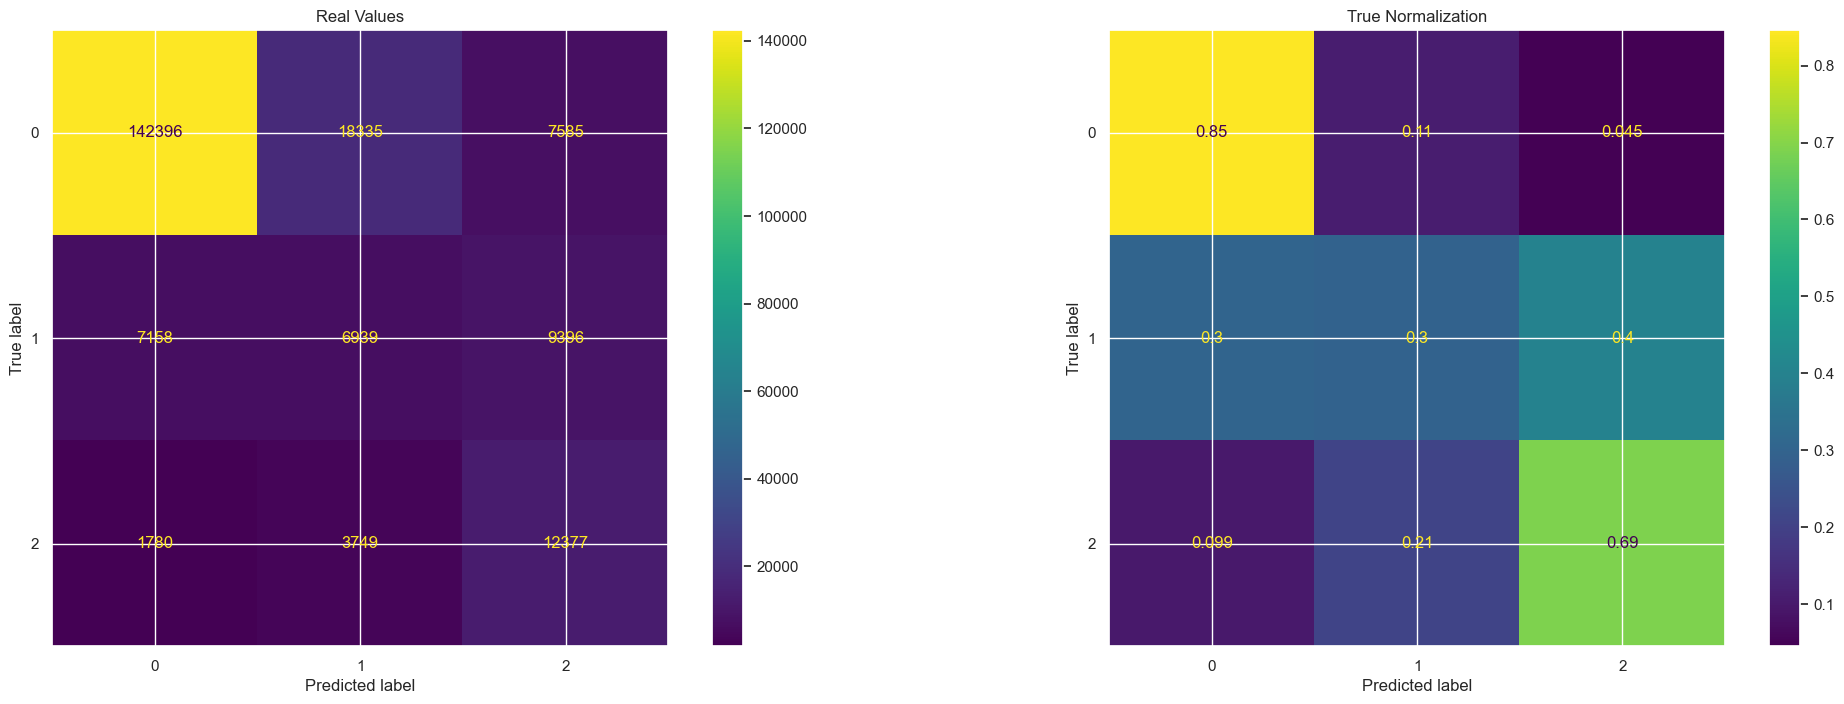

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(25,8))
cm = confusion_matrix(y_test, y_predict)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(ax=ax[0])
ax[0].set_title('Real Values')

cm = confusion_matrix(y_test, y_predict, normalize='true')
ConfusionMatrixDisplay(confusion_matrix=cm).plot(ax=ax[1])
ax[1].set_title('True Normalization')

plt.show()

The lower triangular portion of the central confusion matrix, which represents Type 2 errors, has been significantly reduced. This reduction indicates a lower likelihood of misclassifying high-risk cases as having low severity, aligning with our primary objective of minimizing such errors.

By successfully reducing Type 2 errors, we enhance the model's ability to accurately identify and prioritize high-risk individuals for appropriate intervention and care.

Additionally, we've significantly increased the sensitivity of identifying high-risk cases, which aligns closely with our primary objective. This enhancement ensures that our model is more adept at identifying individuals who require urgent attention and intervention due to their elevated risk of severe outcomes from COVID-19.

In [41]:
df_test.loc[:, "pred"] = y_predict

final_accuracy = accuracy_score(y_test, y_predict)
final_balanced_accuracy = balanced_accuracy_score(y_test, y_predict)

print(f'overall accuracy: {final_accuracy: .2f}')
print(f'overall balanced accuracy: {final_balanced_accuracy: .2f}')


# our sestivity (TPR) of identfying high risk individuals
# TPR = TP / P : positive - high risk (severity 2)
sensitivity = df_test[(df_test["SEVERITY"] == 2) & (df_test["pred"] == 2)].shape[0] / df_test[(df_test["SEVERITY"] == 2)].shape[0]
print(f"Sensitivity (TPR):{sensitivity : .2f}")

# TNR = TN / N : positive - high risk (severity 2)
specificity = df_test[(df_test["SEVERITY"] != 2) & (df_test["pred"] != 2)].shape[0] / df_test[(df_test["SEVERITY"] != 2)].shape[0]
print(f"Specificity (TNR):{specificity : .2f}")

# FNR = FN / P
FNR = df_test[(df_test["SEVERITY"] == 2) & (df_test["pred"] == 0)].shape[0] / df_test[(df_test["SEVERITY"] == 2)].shape[0]
print(f"FNR:{FNR : .2f}, type 2 errors")

overall accuracy:  0.77
overall balanced accuracy:  0.61
Sensitivity (TPR): 0.69
Specificity (TNR): 0.91
FNR: 0.10, type 2 errors


#### Benchmark Comparison

In [42]:
print("Compare with Benchmark Model (relative change):")
print(f"accuracy: {(final_accuracy / benchmark_overall_accuracy)*100 : .2f}%")
print(f"balance accuracy: {(final_balanced_accuracy / benchmark_balanced_accuracy_score)*100 : .2f}%")
print(f"Sensitivity: {(sensitivity / benchmark_sensitivity) * 100 : .2f}%")
print(f"Specificity: {(specificity / benchmark_specificity) * 100 : .2f}%")
print(f"FNR: {(FNR / benchmark_FNR) * 100 : .2f}%")

Compare with Benchmark Model (relative change):
accuracy:  89.42%
balance accuracy:  102.70%
Sensitivity:  142.33%
Specificity:  93.87%
FNR:  35.84%



The significant improvement in our ability to avoid Type 2 errors, as evidenced by the much lower False Negative Rate (FNR), comes with only a slight decrease in overall accuracy and specificity. Furthermore, we observe a substantial increase in the model's ability to identify high-risk individuals, reflected in the considerable rise in sensitivity. Additionally, the balanced accuracy demonstrates a slight increase.

These measurements unequivocally indicate the superiority of the new model over the benchmark, highlighting its enhanced performance in accurately identifying and classifying individuals at risk, especially those with high severity.

#### Sanity Check - Consistency
Sanity check of the model performance

We want to check how features affect the model prediction

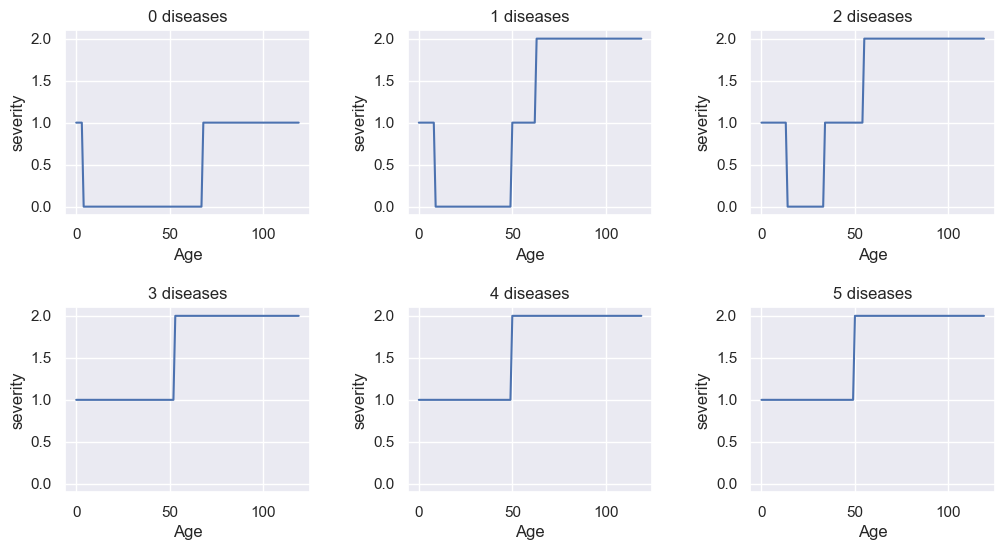

In [43]:
demo_profile_df = pd.DataFrame(index=pd.RangeIndex(1), columns=df_train.columns)
demo_profile_df["SEX"] = 1
demo_profile_df["COVID"] = True
demo_profile_df = demo_profile_df.fillna(False)
demo_profile_df = pd.concat([demo_profile_df]*120,ignore_index=True)
demo_profile_df['AGE'] = np.arange(0, 120)

fig = plt.figure(figsize=(12, 6))
fig.subplots_adjust(hspace=0.5, wspace=0.4)
for i in range(6):
  demo_profile_df["N_BACKGROUND_DISEASES"] = i
  demo_profile_df["SEVERITY"] = clf.predict(demo_profile_df.drop(columns=['SEVERITY']).to_numpy())
  demo_profile_df["SEVERITY"].plot.line(xlabel='Age', ylabel='severity', ylim=(-0.1, 2.1), title=f'{i} diseases', ax=fig.add_subplot(2,3,i+1))

It's evident from our analysis that incorporating both age and the number of diseases as features has resulted in a much smoother signal compared to the benchmark model. This improvement indicates a significant enhancement in the model's consistency and reliability, making it more trustworthy for predictive purposes.

Upon examining the results, several key insights emerge:
- The threshold age indicating high risk tends to decrease as the number of background diseases increases. This suggests that individuals with multiple underlying conditions may face a higher risk of severe outcomes at younger age.

- Overall, the risk tends to be much higher for both older individuals and children compared to young adults. This aligns with our understanding of age as a significant risk factor for severe COVID-19 outcomes.

- In cases where there are no background diseases present, we generally expect a lower risk level. However, it's important to note that monitoring very old people and infants, despite the absence of background diseases, could still be beneficial to ensure their safety and well-being.

These insights underscore the importance of considering both age and underlying health conditions in assessing COVID-19 risk, as they interact in complex ways to influence the severity of outcomes. By incorporating these factors into our predictive model, we can provide more nuanced and accurate risk assessments, ultimately improving patient care and healthcare decision-making.

# Summary
In this experiment, we tackled a challenging tabular data problem aimed at predicting the severity/risk of individuals following COVID-19 test results. Unlike typical mortality prediction tasks (that are commonly used with our dataset), our focus was solely on pre-indicator information, excluding factors like ICU admissions or ventilator usage (those factors are related to the patient future condition that we want to foresee)

Encountering hurdles like unclear features, imbalanced data, missing values, and bias, we employed robust techniques such as feature engineering, augmentations, and oversampling to refine our model for healthcare applicability.
In addition to prioritizing model effectiveness for healthcare applications, we aimed for simplicity in our pipeline design. We opted for the simplest model with fewer features encapsulating the most relevant information, ensuring ease of implementation and maintenance.

By choosing a streamlined approach, we strike a balance between model performance and operational efficiency, making our solution more accessible and sustainable for real-world deployment. This pragmatic decision enables smoother integration into existing healthcare systems, facilitating ongoing monitoring and updates as needed.

Our primary objective was to identify high-risk individuals for intensive care, prioritize sensitivity, and minimize Type 2 errors to avoid misclassifying high-risk cases as low severity. We also emphasized the need for model consistency across similar individuals. changes in certain variables, such as age, would have logical and consistent effects on the predicted risk level, we expected get rational predictions, like that increasing age would correspond to an increased risk of severe outcomes from COVID-19, as older individuals tend to be more vulnerable to complications

Despite a slight dip in overall accuracy comparing to the basic benchmark modeml, the outcome revealed significant enhancements our key objectives. The resulting model exhibits superior suitability for healthcare applications, offering improved sensitivity and reduced Type 2 errors, thus enhancing patient care and management.